# Deep Learning Final Project: Object Recognition using CNN


## Step 1 + 2: Gather Data and Identify Deep Learning Problem

For my Final Project, I am going to attempt to do object recognition with the help of our good friend the convolutional neural network (CNN). Object recognition is a computer vision technique that takes images or video and classifies the objects within them. I will take an image dataset with 7 categories and attempt to categorize them utilizing our CNN model. I will also compare the results of our CNN against a forward feed neural netword (FNN) and a transfer model. I will then analyze the initial results and attempt to improve the model by tuning the hyperparameters.
<br>
<br>
The data for this project comes from this kaggle images dataset: https://www.kaggle.com/datasets/pavansanagapati/images-dataset. 
<br>
<br>
The dataset contains one file titled 'data' with 7 directories. These directories include 'bike', 'cars', 'cats', 'dogs', 'flowers', 'horses', and 'human'. Each of these directories has anywhere from 202-420 images, all of varying sizes. This issue will be addressed in our data cleaning phase.
<br>

## Step 3: Exploratory Data Analysis (EDA) — Inspecting, Visualizing, and Cleaning our Data


### Inspection

The first thing we will do is import all the libraries that we will use for our project and examine how many images we have in each category:

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras_tuner import HyperModel, RandomSearch
from keras_tuner.tuners import Hyperband
from sklearn.utils import class_weight
from keras.layers import BatchNormalization, Activation
from keras.optimizers import Adam
from keras.regularizers import l2


for category in os.listdir('data'):
    print(f"{category}: {len(os.listdir(os.path.join('data', category)))} images")


bike: 365 images
cars: 420 images
cats: 202 images
dogs: 202 images
flowers: 210 images
horses: 202 images
human: 202 images


As we can see, we do indeed have 7 categories of images with varying amounts of photos. Since our classes our slightly unbalanced, we will have to stratify our training and validation subsets before we build our models. But for now, this is ok.

### Visualization
Now, let's take a look at some random images in our dataset, to get an idea of how they look! It may be helpful to run this a few times to see if there are any anomolies in the photos, such as misclassified photos.

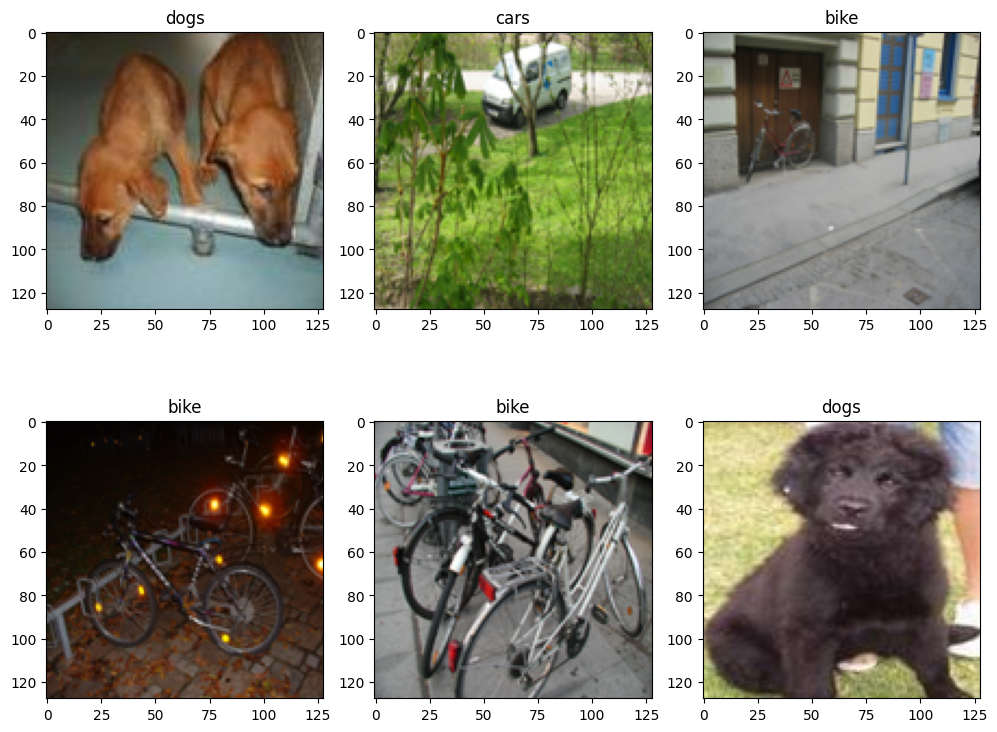

In [2]:
def visualize_sample_images():
    fig, axes = plt.subplots(2, 3, figsize=(10, 8))

    for ax in axes.ravel():
        category = random.choice(os.listdir('data'))
        random_img = random.choice(os.listdir(os.path.join('data', category)))
        img_path = os.path.join('data', category, random_img)
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(category)

    plt.tight_layout()
    plt.show()

visualize_sample_images()

After a few trials, everything looks mostly normal. The only thing that I noticed is that sometimes the object of interest would be off center or really far away in the picture, which may present some challenges for our model later on. <br><br>
Next, let's look at the color histograms of each of our categories. This is where we take the RGB values of each image category and plot them in histograms. This may provide further insight into our image data.

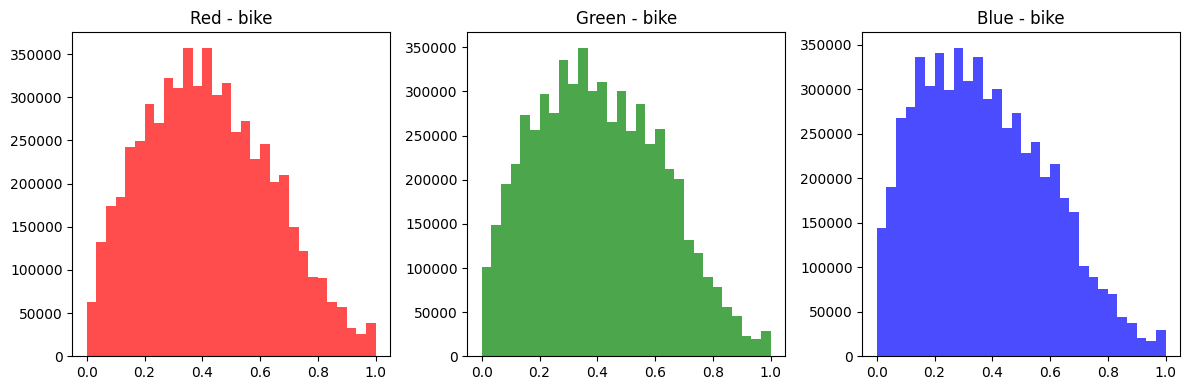

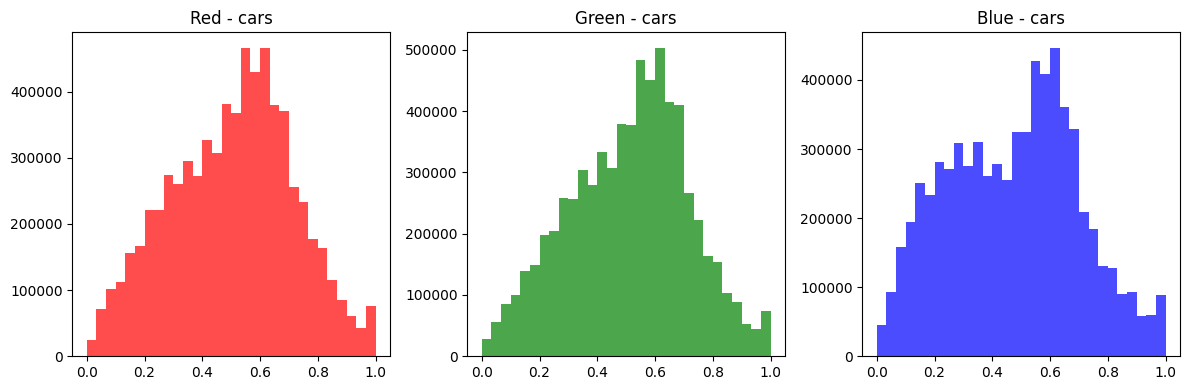

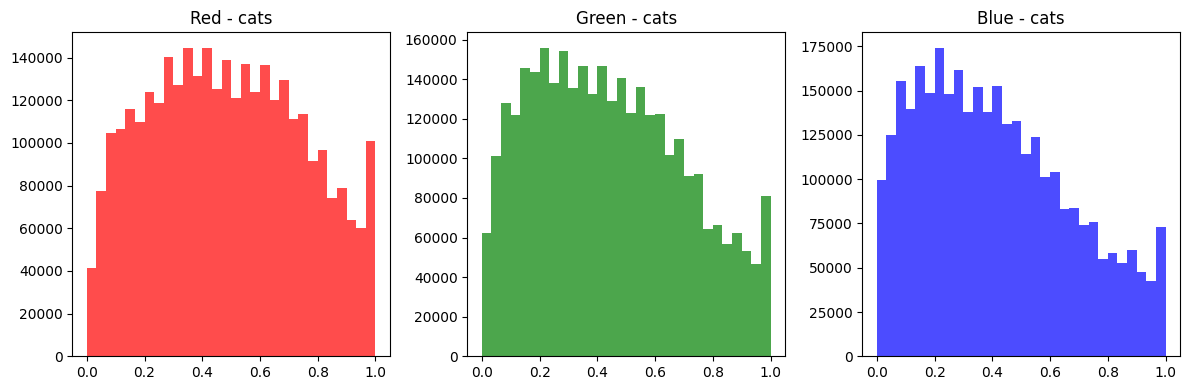

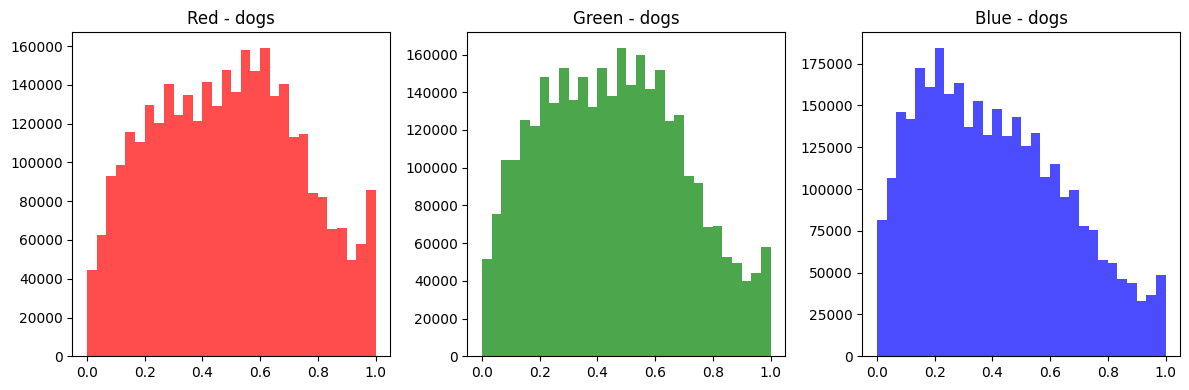

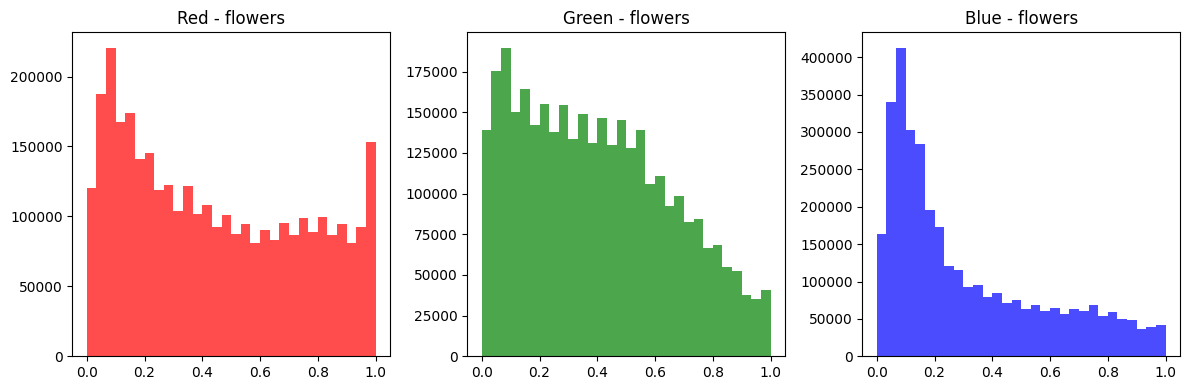

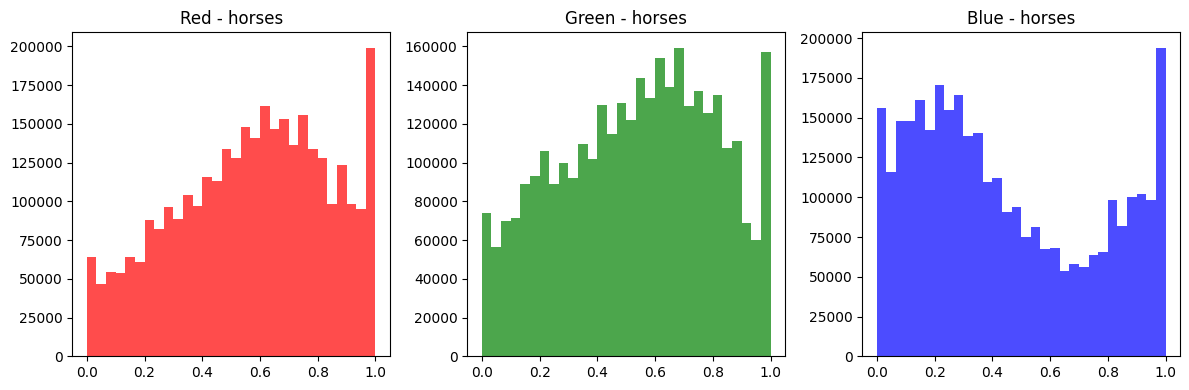

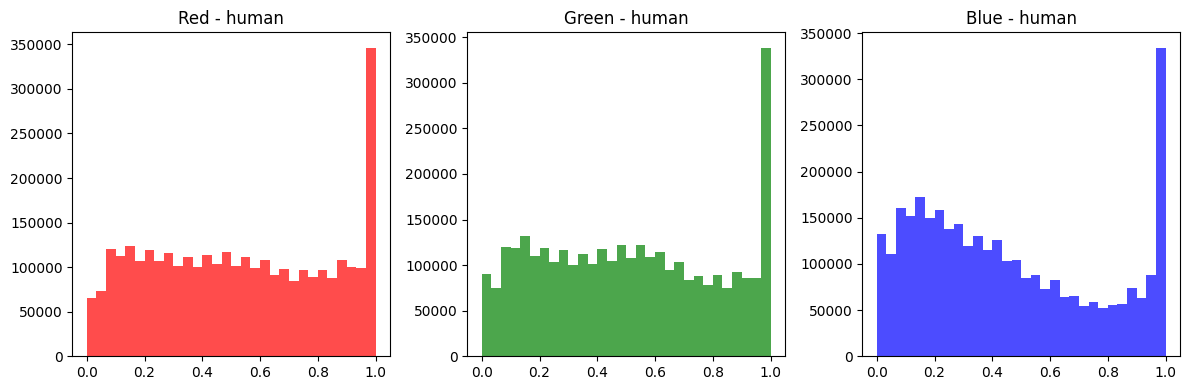

In [3]:
def plot_color_histogram(directory='data'):
    colors = ['Red', 'Green', 'Blue']

    for category in os.listdir(directory):
        all_pixels = {color: [] for color in colors}
        image_paths = [os.path.join(directory, category, img_name) for img_name in os.listdir(os.path.join(directory, category))]

        for img_path in image_paths:
            img = Image.open(img_path)
            img_arr = np.array(img) / 255.0  
            
            for i, color in enumerate(colors):
                all_pixels[color].extend(img_arr[:, :, i].ravel()) 
                
        plt.figure(figsize=(12, 4))
        
        for i, color in enumerate(colors):
            plt.subplot(1, 3, i+1)
            plt.hist(all_pixels[color], bins=30, color=color[0].lower(), alpha=0.7)
            plt.title(f"{color} - {category}")
            
        plt.tight_layout()
        plt.show()

plot_color_histogram()

Looking over the histograms, we can see that (for the most part) each class has a relatively distinct shape. However, there are some that resemble each other such as cats and dogs. This intuitively makes sense, as cats and dogs can certainly look similar.

### Cleaning
Now it's time to move onto the cleaning phase. There are two main tasks that we will be performing in this step. <br><br> 
Step 1.) Look through the directory and see if there are any corrupted images. If there are, they will be removed from the dataset.<br>
Step 2.) Since the images in the dataset are not all the same shape, they will need to be resized to a consistent size. I chose 128 x 128, since there are many images in the dataset that are already this size. This will help minimize issues of distortion.

In [4]:
for category in os.listdir('data'):
    category_path = os.path.join('data', category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        try:
            img = Image.open(img_path) 
            img.verify()  
        except:
            print(f"Corrupted image detected and removed: {img_path}")
            os.remove(img_path)

In [5]:
desired_size = (128, 128)

for category in os.listdir('data'):
    category_path = os.path.join('data', category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = Image.open(img_path)
        img_resized = img.resize(desired_size)
        img_resized.save(img_path)

Now our data is (mostly) clean and we are now ready to move onto the construction of our models! I say mostly clean because it is important to note that we will be transforming our data in the next step, but we will go over that when we get to that step of the process.

## Step 3: Model Architecture


### Reasoning for Model Selection
A CNN is a neural network that is specifically designed for image related tasks. They employ convolutional layers which help it adaptively learn spatial features of the images. I chose this as my main model because they are known to have good performance, good efficiency, and I have experience working with them! <br> <br>
The other two models that we will compare against our CNN will be a forward feed neural network (FNN) and a transfer learning model. <br><br>
A forward-feed neural network (FNN) is a neural network where information moves in only one direction through the layers. I thought it would be interesting to look into an FNN for an image classification task, because they aren't typically known for this task. Also, they are more simple and less resource intensive to train than a CNN. <br><br>
Finally, a transfer learning model is a technique where an already established model is used as a starting point for a new task. For this project, we will be using VGG16. This is a CNN model that has been pre-trained on millions of images from a dataset called ImageNet. Since it is a CNN itself, we can draw comparisons and see if having it be pre-trained helps or hurts its performance. 

### Model Construction
Let's go through the steps of how our model works. We first take in the input shape (which for this project will be 128,128,3) and the number of classes (which will remain constant at 7). Next, there are two convolutional layers, each with 32 neurons. Then, we have a maxpooling layer that reduces the dimensions. We then have a dropoutlayer and a flatten layer. The dropout layer will randomly set 50% of the inputs to 0 and the flatten layer will convert our data into a 1D array. We then go thougha dense layer with 128 neurons with a relu activation function, and then another dropout layer. We then have our final dense layer (our output layer) which will output one of the 7 classes.

In [6]:
def build_cnn(input_shape, num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

### Alternate Model Construction
The next two models we will construct are the FNN and the transfer model. <br><br>
The FNN will have three hidden layers followed by an output layer. <br> The first thing we do is declare that it's sequential. Then, we flatten the input of the image into a 1-d array. We then move onto each hidden layer, which consists of a dense layer and a dropout layer. The first layer has 512 neurons, the second has 256, and the last has 128. After each dense layer is a dropout layer. This is where 50% of the input units are set to 0 at each update during training. This is to help prevent overfitting of our model. Finally, we have our final dense layer which is our output layer. And just like our CNN, we have 7 neurons and our activation function is softmax. <br><br>
The transfer model utilizes the VGG16 architecture. I have opted to make the base layers untrainable, as I want to examine if the pretrained model helps or hurts the performance. The last part of the model is simlar to the opther two: it ends with a softmax activation layer with 7 neurons.

In [7]:
def build_fnn(input_shape, num_classes):
    model = Sequential()
    
    model.add(Flatten(input_shape=input_shape)) 
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [8]:
def build_transfer_model(input_shape, num_classes):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())

    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [9]:
def lr_schedule(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * 0.9

### Model Training and Predictions
There are A LOT of steps to cover for the model training, so get ready. <br><br>
The first thing that we are going to do is initialize some important variables, such as input_shape and all_filenames. We will obtain the class and filenames by traversing the directory. Once we have those, we will then conduct our data split, which will be stratified due to uneven representation of classes. This is an incredibly crucial step which if not completed could result in weird results. We are then going to conduct data augmentation in order to pseudo-expand our dataset (see train_datagen and val_datagen). Next, we calculate the weights for each class, in order to ensure equal representation during training. Then, for the sake of brevity, we will set our optimizers (this will be the same for each model).  <br><br>
After all of that preperation is complete we will then move onto building, compiling, and training our models. The building and compilation step will look similar for all three models, as the optimizer, loss, and metrics values will all be the same. One thing to take note of for the model fit: we will be using a learning rate scheduler (as seen in the box above). This will help encourage convergence, by adjusting the learning rate after a certain epoch has been reached (in this case 5). After the 5th epoch, the learning rate will begin to decay at a rate of lr * .90. <br><br>
As for predictions, I think that the smart guess is that the transfer model will dominate (as it's a pretrained model). The second best will be the CNN, followed by the FNN. 

In [10]:
all_filenames = []
all_classes = []
input_shape = (128, 128, 3)  
num_classes = 7  

for class_name in os.listdir('data'):
    class_dir = os.path.join('data', class_name)
    for filename in os.listdir(class_dir):
        all_filenames.append(os.path.join(class_dir, filename))
        all_classes.append(class_name)

train_files, val_files, train_classes, val_classes = train_test_split(
    all_filenames, all_classes, test_size=0.25, stratify=all_classes, random_state=42
)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': train_files, 'class': train_classes}),
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=64
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'filename': val_files, 'class': val_classes}),
    directory=None,
    x_col='filename',
    y_col='class',
    target_size=(128, 128),
    class_mode='categorical',
    batch_size=64,
    shuffle = False
)

sample_weights = class_weight.compute_sample_weight(class_weight='balanced', y=all_classes)
unique_classes = np.unique(all_classes)
class_weights_dict = {}
for cls in unique_classes:
    class_weights_dict[cls] = np.mean(sample_weights[np.array(all_classes) == cls])
class_weights = {train_generator.class_indices[cls]: weight for cls, weight in class_weights_dict.items()}

fnn_optimizer = Adam(learning_rate=.0005)
cnn_optimizer = Adam(learning_rate=.0005)
transfer_optimizer = Adam(learning_rate=.0005)

fnn_model = build_fnn(input_shape, num_classes)
cnn_model = build_cnn(input_shape, num_classes)
transfer_model = build_transfer_model(input_shape, num_classes)

fnn_model.compile(optimizer=fnn_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
fnn_history = fnn_model.fit(train_generator, epochs=25, validation_data=val_generator, class_weight=class_weights, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)])

cnn_model.compile(optimizer=cnn_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnn_history = cnn_model.fit(train_generator, epochs=25, validation_data=val_generator, class_weight=class_weights, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)])

transfer_model.compile(optimizer=transfer_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
transfer_history = transfer_model.fit(train_generator, epochs=25, validation_data=val_generator, class_weight=class_weights, callbacks=[tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)])

print("\nCNN Model Summary:")
cnn_model.summary()

print("\nFNN Model Summary:")
fnn_model.summary()

print("\nTransfer Learning Model Summary:")
transfer_model.summary()

Found 1352 validated image filenames belonging to 7 classes.
Found 451 validated image filenames belonging to 7 classes.

Epoch 1: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 1/25
22/22 [==============================] - 27s 1s/step - loss: 11.7537 - accuracy: 0.1391 - val_loss: 1.9587 - val_accuracy: 0.1707 - lr: 5.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 2/25
22/22 [==============================] - 8s 378ms/step - loss: 2.1301 - accuracy: 0.1213 - val_loss: 1.9443 - val_accuracy: 0.1131 - lr: 5.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/25
22/22 [==============================] - 8s 372ms/step - loss: 1.9533 - accuracy: 0.1161 - val_loss: 1.9449 - val_accuracy: 0.1153 - lr: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 4/25
22/22 [==============================] - 8s 373ms/step - loss: 1.9554 - 

## Step 4: Results and Analysis
After all the preperation and waiting, it's time to see which model did the best. So let's find out!

In [24]:
def print_final_epoch_stats(history, model_name):
    final_train_loss = history.history['loss'][-1]
    final_train_accuracy = history.history['accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_val_accuracy = history.history['val_accuracy'][-1]

    print(f"{model_name} Final Epoch Stats:")
    print(f"Training Loss: {final_train_loss:.4f}")
    print(f"Training Accuracy: {final_train_accuracy:.4f}")
    print(f"Validation Loss: {final_val_loss:.4f}")
    print(f"Validation Accuracy: {final_val_accuracy:.4f}")
    print("-"*40)

print_final_epoch_stats(cnn_history, "CNN Model")
print_final_epoch_stats(fnn_history, "FNN Model")
print_final_epoch_stats(transfer_history, "Transfer Model")

CNN Model Final Epoch Stats:
Training Loss: 1.2148
Training Accuracy: 0.5762
Validation Loss: 0.9148
Validation Accuracy: 0.6807
----------------------------------------
FNN Model Final Epoch Stats:
Training Loss: 1.9425
Training Accuracy: 0.1095
Validation Loss: 1.9350
Validation Accuracy: 0.1175
----------------------------------------
Transfer Model Final Epoch Stats:
Training Loss: 0.3206
Training Accuracy: 0.9024
Validation Loss: 0.2519
Validation Accuracy: 0.9113
----------------------------------------


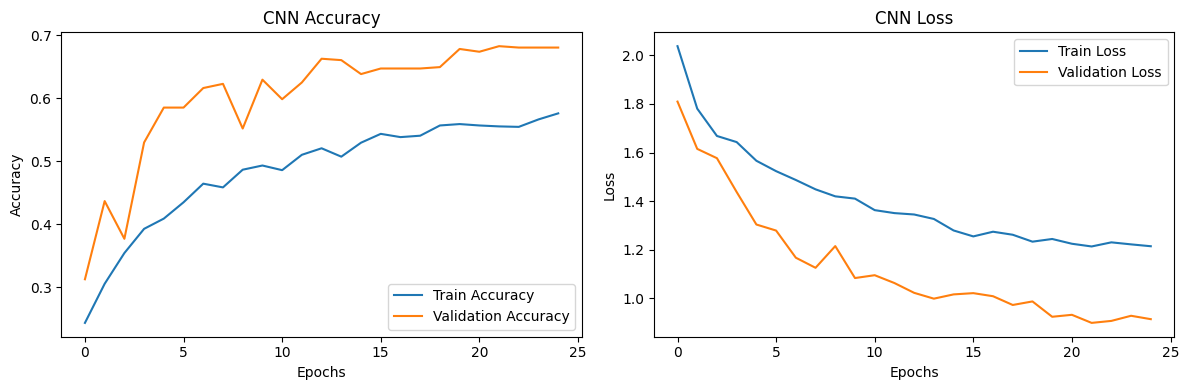

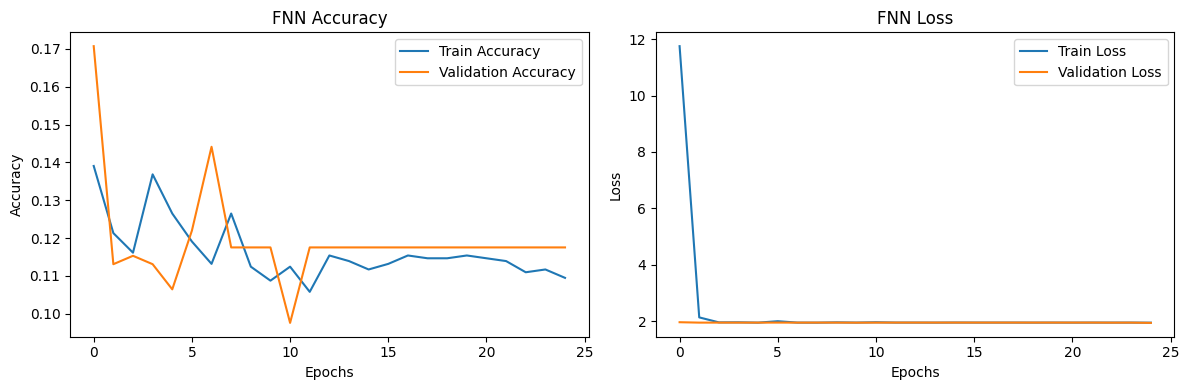

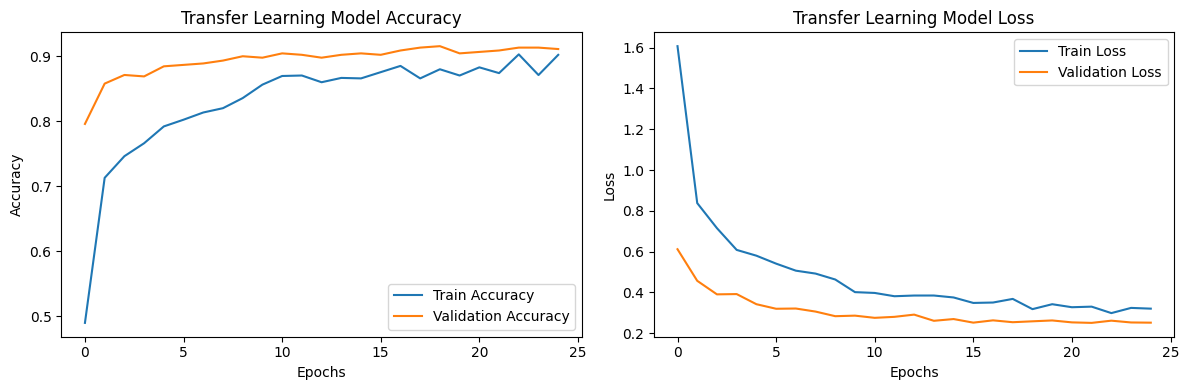

In [11]:
def plot_model_performance(history, title=""):
    plt.figure(figsize=(12, 4))
    
    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f"{title} Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f"{title} Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_model_performance(cnn_history, title="CNN")
plot_model_performance(fnn_history, title="FNN")
plot_model_performance(transfer_history, title="Transfer Learning Model")

8/8 [==============================] - 0s 41ms/step


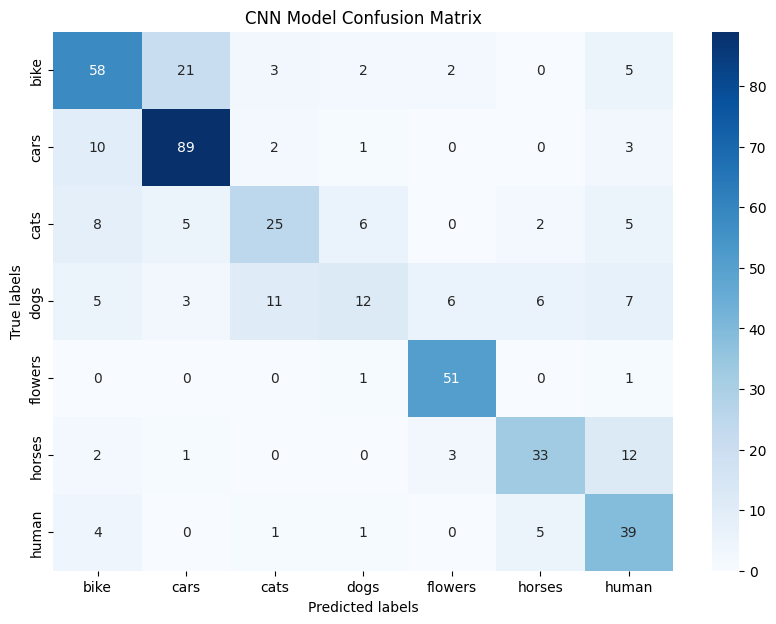

8/8 [==============================] - 0s 17ms/step


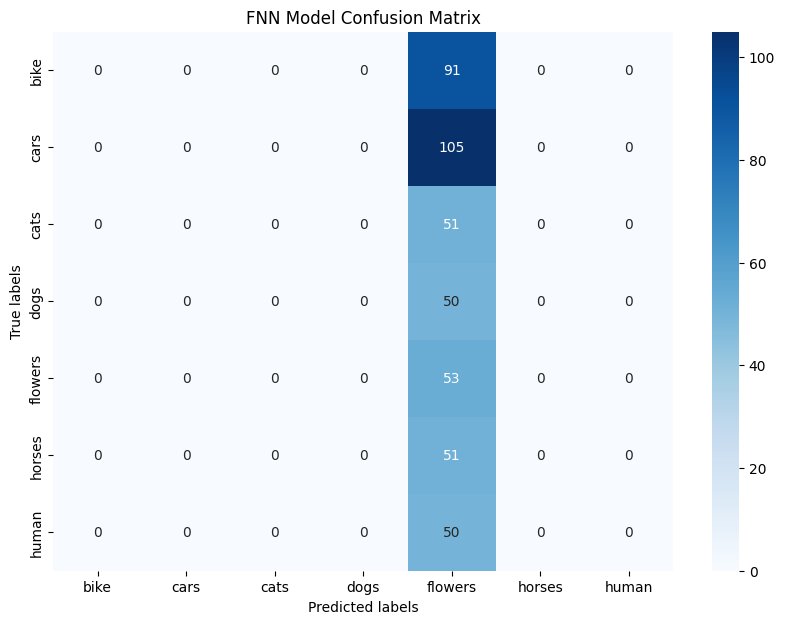

8/8 [==============================] - 4s 453ms/step


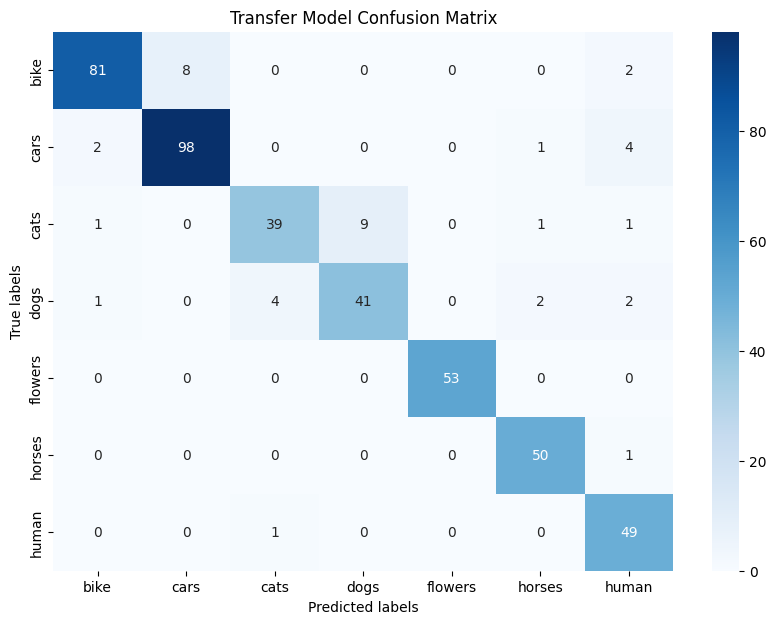

In [23]:
def plot_confusion_matrix(model, generator, title=""):
    y_true = generator.classes

    y_pred = model.predict(val_generator)
    y_pred = np.argmax(y_pred, axis=1)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues',
                xticklabels=generator.class_indices,
                yticklabels=generator.class_indices)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f"{title} Confusion Matrix")
    plt.show()
    
plot_confusion_matrix(cnn_model, val_generator, title = "CNN Model")
plot_confusion_matrix(fnn_model, val_generator, title = "FNN Model")
plot_confusion_matrix(transfer_model, val_generator, title = "Transfer Model")

Very interesting results! For starters, we can see that my predictions were mostly in line, as the transfer model was the top performer on all available metrics and the CNN had moderate performance (with room for improvement). However, I did not forsee a complete and total model collapse! Just take a look at the results for our poor FNN, in particular the confusion matrix. According to him, everything is a flower. While this is sad, this is a good learning oppurtunity. Model collapse can happen for many reasons, such as class imbalance, learning rate issues, etc. We will touch more on this in our conclusion. <br><br>
Another thing to note in our results here is that for our main model, the CNN, the validation accuracy is consistantly beating our train accuracy. This is a really good sign, as it shows that our model is handling unseen data incredibly well. But are there oppurtunities to make it even better?...

### Hyperparameter Tuning & Attempts to Improve Performance
Once again, let's try to make our CNN even better! We can do this by tuning our hyper parameters. We will utilize keras tuner's RandomSearch method to help us in this task. This code will take our base CNN model and use different hyperparameter combinations in order to identify the best possible model. Because our model performed quite well, I've narrowed what our RandomSearch will iterate through.

In [13]:
class CNNHyperModel(HyperModel):

    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()

        model.add(Conv2D(
            filters=hp.Int('conv_1_filters', min_value=16, max_value=64, step=16, default=32),
            kernel_size=hp.Choice('conv_1_kernel', values=[3, 5]),
            activation='relu',
            padding='same',
            input_shape=self.input_shape
        ))

        model.add(Conv2D(
            filters=hp.Int('conv_2_filters', min_value=16, max_value=64, step=16, default=32),
            kernel_size=hp.Choice('conv_2_kernel', values=[3, 5]),
            activation='relu'
        ))

        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Dropout(0.5))

        model.add(Flatten())
        
        model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=32, default=128),
                        activation='relu'))
        model.add(Dropout(0.5))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default=1e-3)),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
        return model

hypermodel = CNNHyperModel(input_shape, num_classes)

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=40,
    directory='hyperband_logs',
    project_name='cnn_tuning'
)

tuner.search(train_generator, epochs=25, validation_data=val_generator, class_weight=class_weights)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

INFO:tensorflow:Reloading Tuner from hyperband_logs\cnn_tuning\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [14]:
best_model.compile(optimizer=best_hps.get('optimizer'),loss='categorical_crossentropy',metrics=['accuracy'])
best_history = best_model.fit(train_generator, epochs=100, validation_data=val_generator)
best_model.summary()

Epoch 1/100
22/22 [==============================] - 19s 779ms/step - loss: 2.7503 - accuracy: 0.2108 - val_loss: 1.7171 - val_accuracy: 0.3769
Epoch 2/100
22/22 [==============================] - 17s 773ms/step - loss: 1.6962 - accuracy: 0.3536 - val_loss: 1.5109 - val_accuracy: 0.4834
Epoch 3/100
22/22 [==============================] - 17s 758ms/step - loss: 1.6542 - accuracy: 0.3913 - val_loss: 1.4759 - val_accuracy: 0.4634
Epoch 4/100
22/22 [==============================] - 17s 751ms/step - loss: 1.4973 - accuracy: 0.4475 - val_loss: 1.3700 - val_accuracy: 0.5055
Epoch 5/100
22/22 [==============================] - 17s 755ms/step - loss: 1.4328 - accuracy: 0.4660 - val_loss: 1.1569 - val_accuracy: 0.5676
Epoch 6/100
22/22 [==============================] - 17s 759ms/step - loss: 1.4595 - accuracy: 0.4712 - val_loss: 1.1968 - val_accuracy: 0.6009
Epoch 7/100
22/22 [==============================] - 17s 751ms/step - loss: 1.3519 - accuracy: 0.5037 - val_loss: 1.0675 - val_accuracy:

### Tuned Model Performance
Time to see if tuning the model was worth it...

CNN Model Final Epoch Stats:
Training Loss: 1.2148
Training Accuracy: 0.5762
Validation Loss: 0.9148
Validation Accuracy: 0.6807
----------------------------------------
Tuned CNN Model Final Epoch Stats:
Training Loss: 0.6844
Training Accuracy: 0.7552
Validation Loss: 0.5544
Validation Accuracy: 0.7916
----------------------------------------


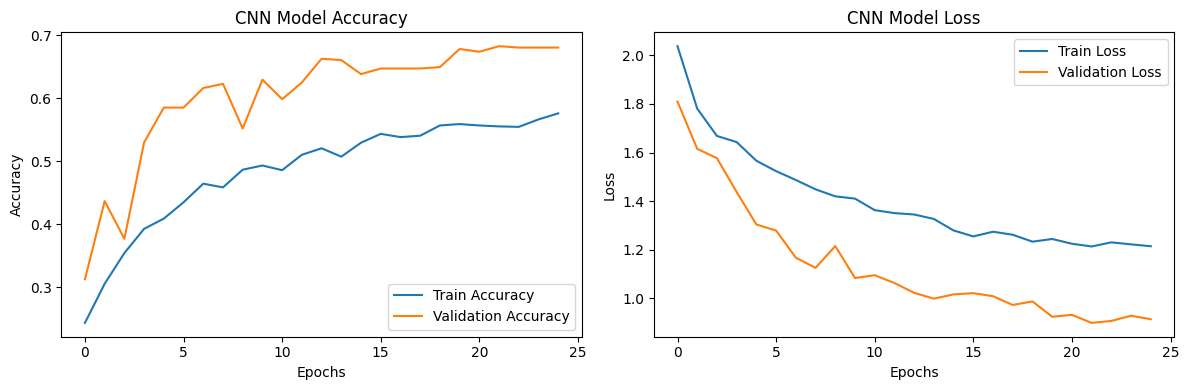

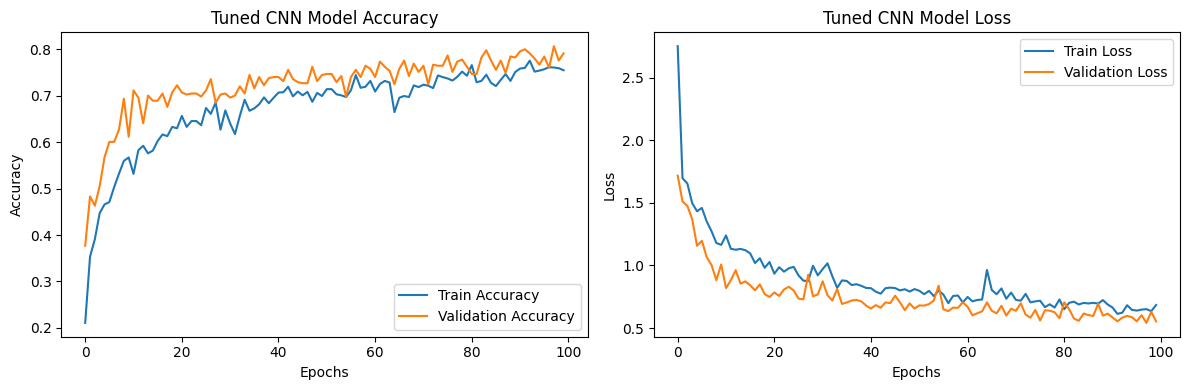

In [26]:
print_final_epoch_stats(cnn_history, "CNN Model")
print_final_epoch_stats(best_history, "Tuned CNN Model")

plot_model_performance(cnn_history, title="CNN Model")
plot_model_performance(best_history, title="Tuned CNN Model")

8/8 [==============================] - 1s 66ms/step


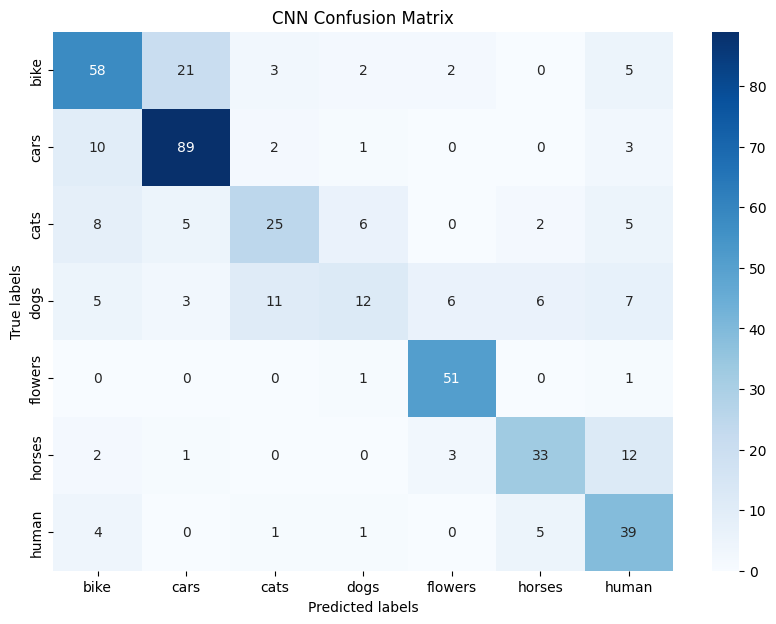

8/8 [==============================] - 1s 79ms/step


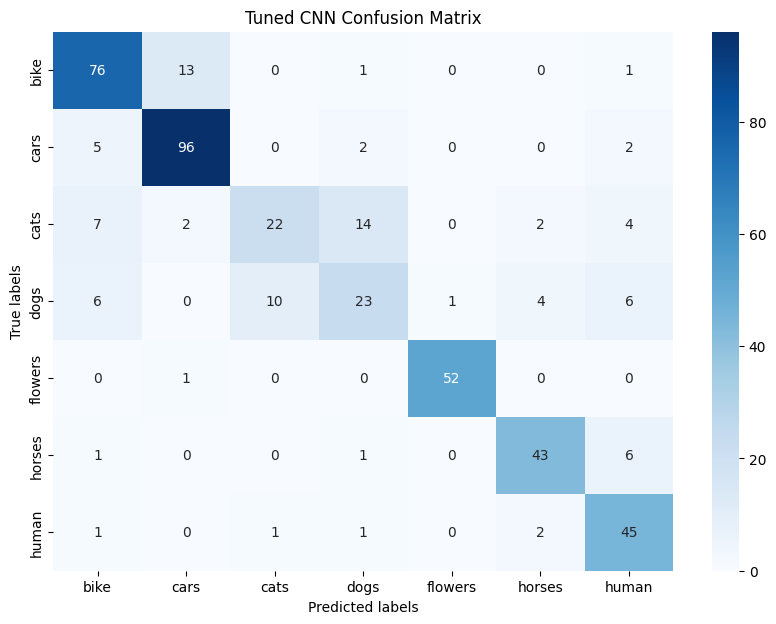

In [19]:
plot_confusion_matrix(cnn_model,val_generator, title = "CNN")
plot_confusion_matrix(best_model, val_generator, title = "Tuned CNN")

 Overall, I would say that the tuning process has been relatively successful. There has been an improvement on our CNN model's validation accuracy (with an increase of roughly 11%). Both the training and validation losses have gone down, which indicates a better fit. With more time, it's possible we could optimize the model even further. <br><br> One interesting thing: both the base model and the tuned model seem to have the most trouble in telling cats and dogs apart (remember the color histograms earlier?). 

## Step 5: Conclusion
I found this project to be incredibly fun and insightful. The first thing I tookaway from this project is that choosing the correct model architecture matters, because if you don't there could be unintended consequences (like with our FNN). Speaking of our FNN, sometimes model collapse happens and it can be a real hassle to figure out why. I attempted to correct the problem multiple times, but it was computationally expensive and time consuming, so I had to abandon trying to fix that model and focus on the others. I also realized how tricky it can be to navigate unbalanced datasets and the challenges that come with it. I could have very easily chose a dataset that was balanced, but data in the real world is rarely set up that way. I wanted something that is more representative of a real world situation. I was also incredibly impressed with how well our transfer learning model performed and learned what a good tool they can be in certain situations. <br><br>
If I had to do this project over again, there are a couple things I would change. I would first use a larger dataset that is more diverse and balanced. This would help improve the performance of my model. I would also experiment with more types of neural network models, in order to compare and contrast their performance.  